In [1]:
# This notebook makes setolabo samples as test samples. 
# using new kagawa samples only for training.
# I will be using NDP and BC samples only. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Define a function to calculate median of the 6 closest non-NaN values
def fill_with_closest_median_or_zero(column):
    # Create a copy of the column to avoid modifying in place
    filled_column = column.copy()
    for idx in column[column.isna()].index:  # Find indices of NaN values
        # Get the 3 previous and 3 next valid (non-NaN) values
        window = column[max(0, idx - 3): idx + 4].dropna()
        if len(window) > 0:
            # Compute the median of up to 6 closest values
            filled_column[idx] = window.median()
        else:
            # Fill with 0 if no valid values are found
            filled_column[idx] = 0
    return filled_column

In [4]:
path = 'E:/MedBank/head_model/NGS/data_shared_by_Takeshi-san/'
df_kagawa = pd.read_csv(path+'kagawa/AVITI/AVITI_mirna_count_matrix3.csv')
df_seto = pd.read_csv('E:/MedBank/head_model/NGS/data_shared_by_Takeshi-san/expression_count_test_20240807.csv')



common_miRNA = set(df_kagawa['miRNA']) & set(df_seto['gene_id'])  

df_kagawa = df_kagawa[df_kagawa['miRNA'].isin(common_miRNA)].sort_values(by='miRNA')
df_kagawa = df_kagawa.drop_duplicates(subset='miRNA', keep='first')

df_seto = df_seto[df_seto['gene_id'].isin(common_miRNA)].sort_values(by='gene_id')









# df_breast_labels = [0] * 27 + [1] * 9  # Last 9 columns are control # 0 for breast cancer # 1 for control
df_kagawa_labels = []
for col in df_kagawa.columns[1:]:
    if col.startswith('BC'):
        df_kagawa_labels.append(0)  # Breast cancer
    elif col.startswith('NDP'):
        df_kagawa_labels.append(1) 
    elif col.startswith('LiverC'):
        # df_kagawa_labels.append(2) 
        df_kagawa.drop(columns=[col], inplace=True)
    elif col.startswith('ColoC'):
        df_kagawa.drop(columns=[col], inplace=True) 
    elif col.startswith('Other'):
        df_kagawa.drop(columns=[col], inplace=True) 
    elif col.startswith('PanC'):
        df_kagawa.drop(columns=[col], inplace=True) 
    elif col.startswith('BrainT'):
        df_kagawa.drop(columns=[col], inplace=True)                     

# Combine all datasets column-wise while avoiding duplicate 'miRNA' columns
combined_df = pd.concat(
    [df_kagawa.set_index('miRNA')
     ], 
    axis=1
).reset_index()

# combined_df = df_kagawa.set_index('miRNA').reset_index()

features = combined_df['miRNA']

# Seto dataset labels (test set, all BC samples)
labels_seto = [0 for _ in range(5)]
# labels_train = labels_lung + df_colo_labels + df_gast_labels + df_breast_labels
labels_train = df_kagawa_labels




# Transpose the DataFrames and reset their index
combined_df = combined_df.T
df_seto = df_seto.T
combined_df.reset_index(drop=True, inplace=True)
df_seto.reset_index(drop=True, inplace=True)

# Update the column names after transposing
df_seto.columns = df_seto.iloc[0].tolist()
df_seto = df_seto[1:]
combined_df.columns = combined_df.iloc[0].tolist()
combined_df = combined_df[1:]

# Assign labels to the GRE and seto datasets
combined_df['labels'] = labels_train
df_seto['labels'] = labels_seto

# No train-test split, combined_df is the full training set and df_seto is the testing set
df_train = combined_df.iloc[:, :-1]  # Features of the full training set
df_train = df_train.apply(fill_with_closest_median_or_zero)
# df_test = df_seto.iloc[:, :-1]  # Features of the full testing set <---- #uncomment 

# Create labels_train and labels_test
labels_train = combined_df['labels'].tolist()
# labels_test = df_seto['labels'].tolist()  <---- #uncomment 




Correlation code 

In [8]:
def process(df, labels):
    df = df.T  # Transpose the DataFrame
    df.reset_index(drop=True, inplace=True)  # Reset the index
    df.columns = df.iloc[0].tolist()  # Set the first row as column names
    df = df[1:]  # Drop the first row after setting column names
    df['labels'] = labels  # Add labels column
    df = df.iloc[:, :-1]  # Drop the labels column (to match the original behavior)
    df = df.apply(fill_with_closest_median_or_zero)
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
    return df
df_test = df_test.apply(pd.to_numeric, errors='coerce')

 


Plotting

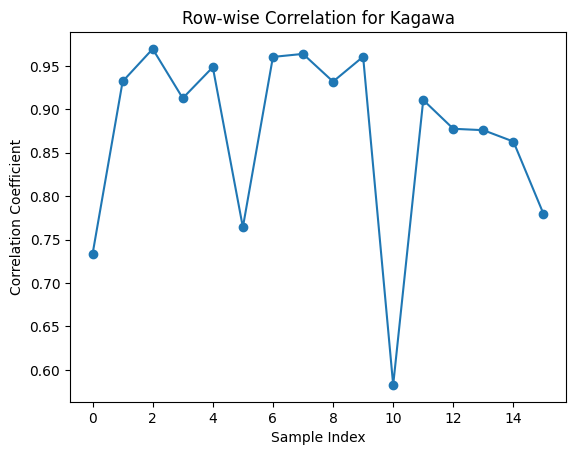

In [9]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
# List of datasets and their corresponding labels
datasets = [df_kagawa]
labels_list = [df_kagawa_labels]
dataset_names = ['Kagawa']

# Loop through each dataset and plot the row-wise correlation
for idx, (df, labels) in enumerate(zip(datasets, labels_list)):
    processed_df = process(df, labels)

    # Align the datasets row-wise (transpose if needed for row-wise operations)
    lung_rows = processed_df.to_numpy()
    test_rows = df_test.to_numpy()

    # Ensure the row dimensions match
    min_samples = min(len(lung_rows), len(test_rows))
    lung_rows = lung_rows[:min_samples]
    test_rows = test_rows[:min_samples]

    # Compute row-wise correlations
    row_correlations = [
        pearsonr(lung_rows[i], test_rows[i])[0] for i in range(min_samples)
    ]

    # Plotting the row-wise correlation for each dataset
    plt.figure(idx)
    plt.plot(row_correlations, marker='o')
    plt.title(f"Row-wise Correlation for {dataset_names[idx]}")
    plt.xlabel("Sample Index")
    plt.ylabel("Correlation Coefficient")
    plt.show()

In [10]:
#outliers removal and normalization
def normalize_entire_dataset(df_train, df_test):
    # Combine train and test DataFrames
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    
    # Flatten the entire dataset into a single array and normalize
    min_val = combined_df.min().min()  # Minimum value across all elements
    max_val = combined_df.max().max()  # Maximum value across all elements
    
    # Avoid division by zero if all values are constant
    if max_val != min_val:
        combined_df = (combined_df - min_val) / (max_val - min_val)
    
    # Separate the DataFrames back into train and test
    df_train_normalized = combined_df.iloc[:len(df_train), :].reset_index(drop=True)
    df_test_normalized = combined_df.iloc[len(df_train):, :].reset_index(drop=True)
    
    return df_train_normalized, df_test_normalized



# df_train = normalize_dataset(df_train)
# df_test = normalize_dataset(df_test)
df_train, df_test = normalize_entire_dataset(df_train, df_test)


In [11]:
# Define NGS version as a variable
# folder_path = "E:/MedBank/head_model/head/work_dir/model_ready_folders/setolabo_samples_as_test/FD3"  # You can change this value as needed
folder_path = "E:/MedBank/head_model/NGS/data_shared_by_Takeshi-san/model_ready_folders/setolabo_samples_as_test/kagawa3"  # You can change this value as needed

# Paths for train and test feature vectors
file_path = f"{folder_path}/train/feature_vectors.csv"
df_train.to_csv(file_path, index=False, header=False)

file_path = f"{folder_path}/test/feature_vectors.csv"
df_test.to_csv(file_path, index=False, header=False)

##--------------------------------------------------------

# Paths for train and test labels
file_path = f"{folder_path}/train/labels.txt"
with open(file_path, 'w') as file:
    for label in labels_train:
        file.write(f"{label}\n")

file_path = f"{folder_path}/test/labels.txt"
with open(file_path, 'w') as file:
    for label in labels_test:
        file.write(f"{label}\n")

##--------------------------------------------------------

# Path for feature names
file_path = f"{folder_path}/feature_names.txt"
with open(file_path, 'w') as file:
    for label in features:
        file.write(f"{label}\n")